In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from hw2 import get_mnist_threes_nines, display_image

Finite difference checker for computing gradient of function f, input x with respect to k. 

In [18]:

epsilon = 10**(-5)
def finite_difference_checker(f, x, k):
    """Returns \frac{\partial f}{\partial x_k}(x)"""
    # YOUR CODE HERE
    x_add_epsilon = [0 for i in x]
    x_add_epsilon[k] = epsilon
    x_add_epsilon = x+x_add_epsilon
    x_sub_epsilon = [0 for i in x]
    x_sub_epsilon[k] = epsilon
    x_sub_epsilon = x-x_add_epsilon
    derivative = (f(x_add_epsilon)-f(x_sub_epsilon))/2*epsilon
    #derivative = (f(x+epsilon)-f(x-epsilon))/2*epsilon

    return derivative

Activation and loss function for the neural network

In [19]:
from cmath import log
from functools import cache

from numpy import vectorize


def sigmoid(num):
    return 1/(1+np.exp(-num))
    
def sigmoid_activation(x):

    out = np.where(x<0, np.exp(x), 1)/(1+np.where(x<0, np.exp(x), np.exp(-x)))
    np.clip(out,10**(-15), 1-10**(-15))
    grad = out*(1-out)
    return out, grad


def log_loss(x):
    return -np.log((x[0]**x[1])*(1-x[0]**(1-x[1])))

def logistic_loss(g, y):
    """
    Computes the loss and gradient for binary classification with logistic
    loss

    Inputs:
    - g: Output of final layer with sigmoid activation,
         of shape (n, 1) 

    - y: Vector of labels, of shape (n,) where y[i] is the label for x[i] 
         and y[i] in {0, 1}

    Returns a tuple of:
    - loss: array of losses
    - dL_dg: Gradient of the loss with respect to g
    """

    loss = -(y * np.log(g) + (1 - y) * np.log(1 - g))
    dL_dg =  -(((y / g) + (y - 1)/(1 - g)))/len(g)
    return loss, dL_dg

def relu_activation(s):

    out = np.where(s<0, 0, s)
    ds = np.where(s<0, 0.0, 1.0)
    return out, ds

def layer_forward(x, W, b, activation_fn):

    result = x@W+b
    out, grad = activation_fn(result)
    cache = (grad, x, W)
    return out, cache

Output of sigmoid activation function with given input

In [20]:
s = np.asarray([1., 0., -1])
out, grad = sigmoid_activation(s)

with np.printoptions(precision=2):
    print(out)
    print(grad)
    
print("="*80)

# 1.3b ii
s = np.asarray([-1000., 1000.])
out, grad = sigmoid_activation(s)
print(out)
print(grad)

[0.73 0.5  0.27]
[0.2  0.25 0.2 ]
[0. 1.]
[0. 0.]


/var/folders/vt/385jmswn46l_nsyn68syvb9h0000gn/T/ipykernel_67601/1963451303.py:12: RuntimeWarning: overflow encountered in exp
  out = np.where(x<0, np.exp(x), 1)/(1+np.where(x<0, np.exp(x), np.exp(-x)))


 Initializing the neural network's weights. forward pass function implemented which ties everything together, computing the output of a neural network with weights given by `weight_matrices` + `biases`, activation functions given by `activations`, on the input `X_batch`, a 2d input where each row is an individual input vector)

In [21]:
def create_weight_matrices(layer_dims):
    """
    Creates a list of weight matrices defining the weights of NN
    
    Inputs:
    - layer_dims: A list whose size is the number of layers. layer_dims[i] defines
      the number of neurons in the i+1 layer.

    Returns a list of weight matrices
    """
    # YOUR CODE HERE
    #arr = np.vectorize(create_weight_layer)
    #weights = arr(layer_dims)
    weights = []
    for i in range (len(layer_dims)-1):
        rows = layer_dims[i] 
        columns = layer_dims[i+1]
        weights.append(np.random.randn(rows, columns)*np.random.normal(0, 0.01))
    return weights

def create_bias_vectors(layer_dims):
    # YOUR CODE HERE
    biases = []
    #for i in range(len(layer_dims)-1):
    #    biases.append(np.random.randn(1,i)*np.random.normal(0, 0.01))
    biases = [np.random.randn(1, h)* 0.01 for h in layer_dims[1:]]
    return biases

def forward_pass(X_batch, weight_matrices, biases, activations):
    # YOUR CODE HERE

    caches = []
    for x in range(len(weight_matrices)):
        X_batch, cache_x = layer_forward(X_batch, weight_matrices[x], biases[x], activations[x])
        caches.append(cache_x)
    return X_batch.flatten(), caches

Testing output of the lossfunction (i.e the loss and gradient of the logistic loss functoion) with given pickle file

In [22]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)
activations = [relu_activation, sigmoid_activation]
output, _ = forward_pass(X_batch, weight_matrices, biases,
                         activations)
loss, dL_dg = logistic_loss(output, y_batch)
print(loss.mean())

0.6985168038536878


Backward pass

In [23]:
def backward_pass(dL_dg, layer_caches):
    grad, x, W = layer_caches[::-1][0]
    ### 0 = grad, 1 = x, 2 = W, 3 = b ###
    depth = len(layer_caches)
    delta = np.multiply(dL_dg.reshape(len(dL_dg), -1), grad)
    grad_Ws = [np.dot(x.T, delta)]
    #grad_Ws = [np.dot(layer_caches[depth-1][4].T, dW)]
    grad_bs = [np.sum(delta, axis=0)]

    for l in reversed(list(layer_caches[:-1])):

     grad, x, W = l
     delta = np.multiply(delta, grad)
     gradW = np.dot(x.T, delta)
     grad_Ws.insert(0, gradW)
     grad_bs.insert(0, np.sum(delta))
     delta = np.dot(delta, W.T).reshape(x.shape)


    return grad_Ws, grad_bs


Output of backward pass

In [24]:
with open("test_batch_weights_biases.pkl", "rb") as fn:
    (X_batch, y_batch, weight_matrices, biases) = pickle.load(fn)

activations = [relu_activation, sigmoid_activation]
output, layer_caches = forward_pass(X_batch, weight_matrices, biases,
                                    activations)
loss, dL_dg = logistic_loss(output, y_batch)

grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)

with np.printoptions(precision=2):
    print(grad_Ws[0])
    print()
    print(grad_Ws[1])
    print()
    print(grad_bs[0])
    print()
    print(grad_bs[1])

[[ 0.09 -0.16]
 [-0.01 -0.1 ]
 [-0.27 -0.37]
 [ 0.05  0.01]]

[[-0.  ]
 [-0.01]]

-0.7540152986252404

[-0.5]


Training of neural network using Stochastic gradient descent algorithm

In [61]:
from itertools import count
from multiprocessing.sharedctypes import Value
from nis import cat
import random

(X_train, y_train), (X_test, y_test) = get_mnist_threes_nines()
# YOUR CODE HERE
layer_dims = [784, 200,1]
step_size = 0.1
weights = create_weight_matrices(layer_dims)
biases = create_bias_vectors(layer_dims)
activations = [relu_activation, sigmoid_activation]
batch_size = 100
traning = []
traning_loss = []
test = []
test_loss = []
xbatch_test = X_test
ybatch = y_train
ybatch_test = y_test
epochs = 10

def calculate_accuracy_and_loss(xbatch, ybatch, trainingdata):
     for m_batch in range(int(xbatch.shape[0]/batch_size)):
        #creating minibatches
        #Computation of batch size, inspiration from 
        #https://realpython.com/gradient-descent-algorithm-python/#stochastic-gradient-descent-algorithms
        start = m_batch * batch_size
        stop = start+batch_size
        minibatch = random_x[start : stop]
        Xbatch = xbatch[minibatch].reshape(xbatch[minibatch].shape[0], -1)
        Ybatch = ybatch[minibatch]
        #Computing forward pass
        output, layer_caches = forward_pass(Xbatch, weights, biases, activations)
        #Computing loss
        loss, dL_dg = logistic_loss(output, Ybatch)
        if trainingdata:
            traning_loss.append(loss.mean())
        else:
            test_loss.append(loss.mean())
        #Computing backward pass
        grad_Ws, grad_bs = backward_pass(dL_dg, layer_caches)
        #Updating weights
        for layer in range(len(weights)):
            weights[layer] -= step_size*grad_Ws[layer]
            biases[layer] -= step_size* grad_bs[layer]
        output_classification = []
        count = 0
        for i in output:
            if i >=0.5:
                output_classification.append(1)
            else:
                output_classification.append(0)
        for i in range(len(Ybatch)):
            if Ybatch[i]==output_classification[i]:
                count+=1
        accuracy = count/len(Ybatch)
        if trainingdata:
            traning.append(accuracy)
        else:
            test.append(accuracy)
        print("accuracy: ", accuracy)

for e in range(epochs):
    random_x = np.random.permutation(X_train.shape[0])
    #for i in range (xbatch.shape[0]):
    #    random_x.append(random.randint(0,xbatch.shape[0]))
    calculate_accuracy_and_loss(X_train, y_train, True)
    random_x = np.random.permutation(X_test.shape[0])
    calculate_accuracy_and_loss(X_test, y_test, False)

accuracy:  0.55
accuracy:  0.5
accuracy:  0.77
accuracy:  0.43
accuracy:  0.9
accuracy:  0.59
accuracy:  0.8
accuracy:  0.75
accuracy:  0.63
accuracy:  0.81
accuracy:  0.94
accuracy:  0.91
accuracy:  0.92
accuracy:  0.96
accuracy:  0.95
accuracy:  0.92
accuracy:  0.89
accuracy:  0.93
accuracy:  0.93
accuracy:  0.98
accuracy:  0.92
accuracy:  0.95
accuracy:  0.88
accuracy:  0.95
accuracy:  0.93
accuracy:  0.99
accuracy:  0.93
accuracy:  0.97
accuracy:  0.93
accuracy:  0.96
accuracy:  0.97
accuracy:  0.95
accuracy:  0.98
accuracy:  0.94
accuracy:  0.93
accuracy:  0.94
accuracy:  0.97
accuracy:  0.92
accuracy:  0.99
accuracy:  0.94
accuracy:  0.96
accuracy:  0.93
accuracy:  0.95
accuracy:  0.95
accuracy:  0.95
accuracy:  0.98
accuracy:  0.93
accuracy:  0.96
accuracy:  0.96
accuracy:  0.94
accuracy:  0.93
accuracy:  0.95
accuracy:  0.92
accuracy:  0.95
accuracy:  0.95
accuracy:  0.96
accuracy:  0.94
accuracy:  0.95
accuracy:  0.94
accuracy:  0.96
accuracy:  0.95
accuracy:  0.97
accuracy:  

1.3e code answers for i, ii, iii

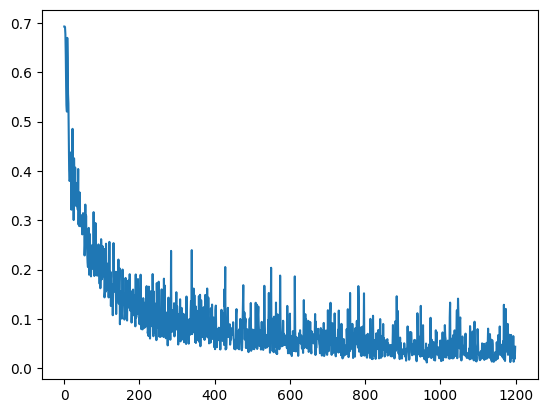

In [62]:
# i
# Plot the train and test losses from the MNIST network with step size = 0.1
# YOUR CODE HERE
#I am plotting all 4 plots individually. This is plot for training loss
plt.plot(traning_loss, label="Training loss")
plt.show()

# iii
# Visualize (plot) some images that are misclassified by your network

In [65]:
# i
# Plot the train and test losses from the MNIST network with step size = 0.1
plt.plot(test_loss, label="Test loss")

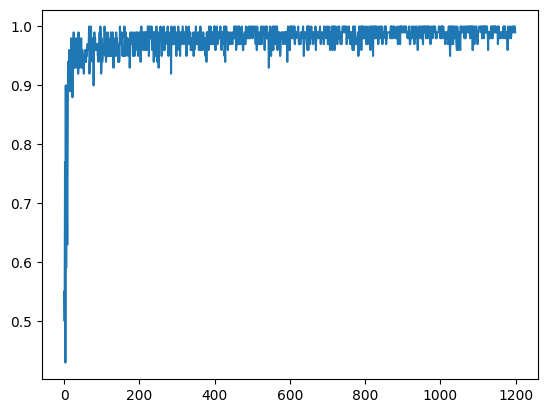

In [64]:
# ii
# Plot the train and test accuracies from the MNIST network with step size = 0.1
# YOUR CODE HERE
plt.plot(traning, label="Training accuracy")


In [67]:
# ii
# Plot the train and test accuracies from the MNIST network with step size = 0.1
# YOUR CODE HERE
plt.plot(test, label="Test accuracy")
plt.show()

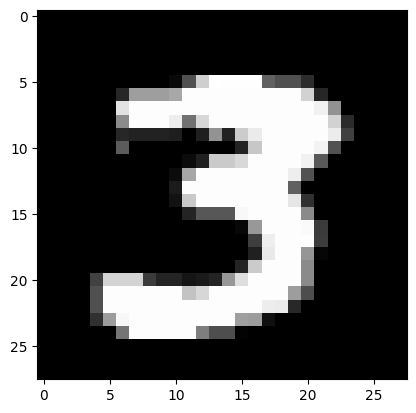

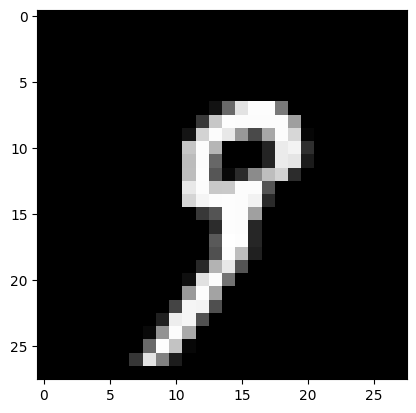

In [40]:
display_image(X_train[6])
display_image(X_train[4])

The neural network is classifying 3 and 9 with an accuracy of 98%. 